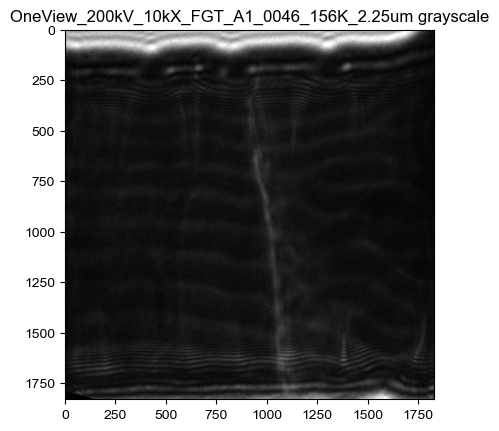

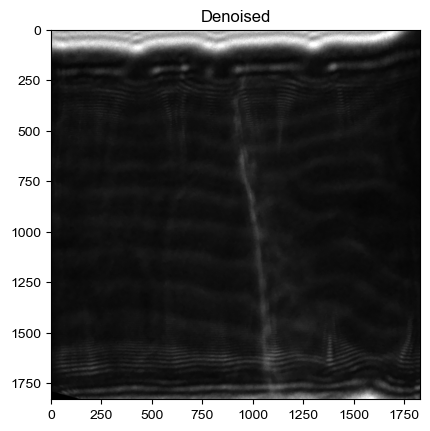

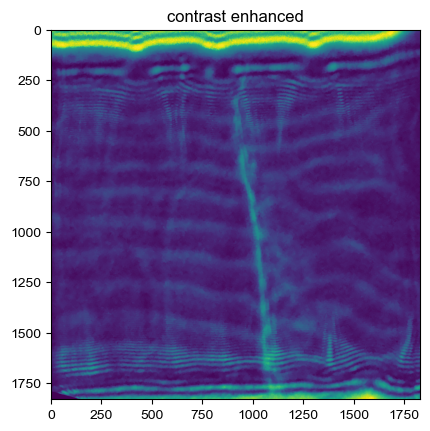

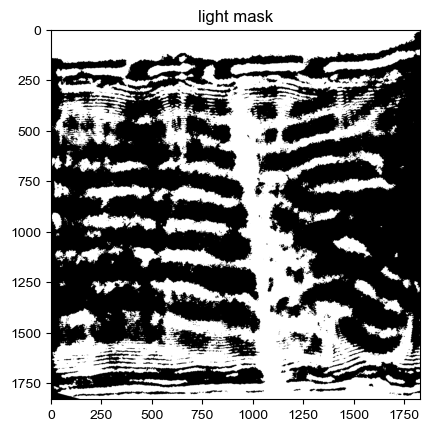

(1831, 1831)
light_pixels 1475446
total_pixels 3352561
dark_pixels 1877115
ratio 0.4400951988643905
OneView_200kV_10kX_FGT_A1_0046_156K_2.25um.png ratio of light pixels to total pixels:  0.4400951988643905


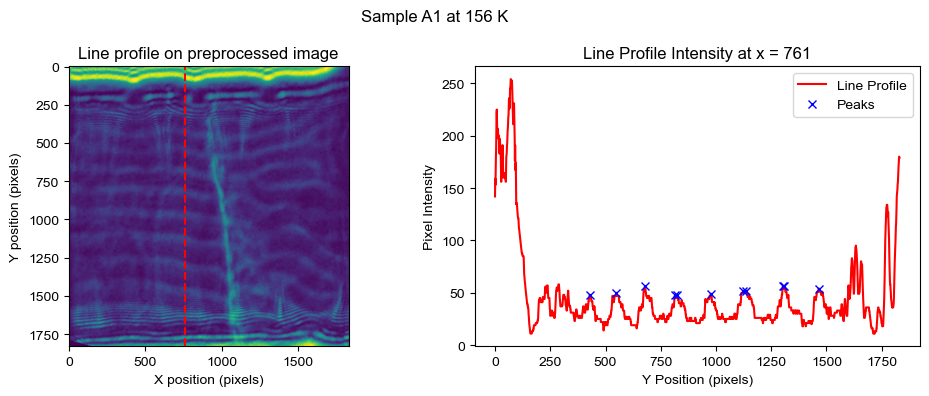

Number of peaks: 11
Average peak-to-peak spacing: 103.60 pixels
peak- to-peak spacing Stdev: 63.23 pixels


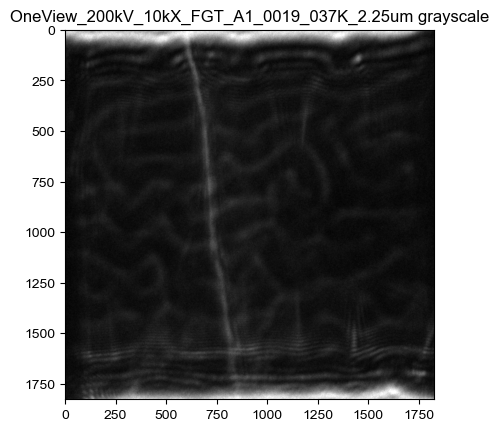

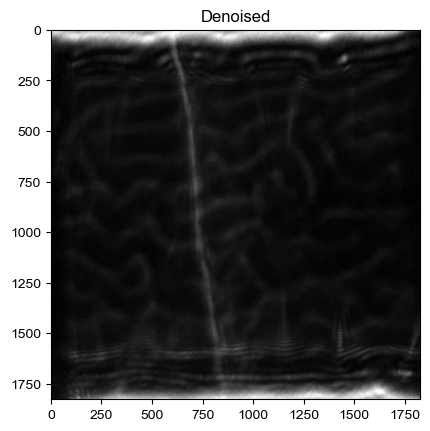

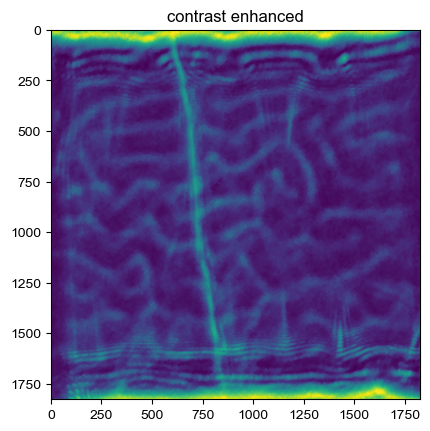

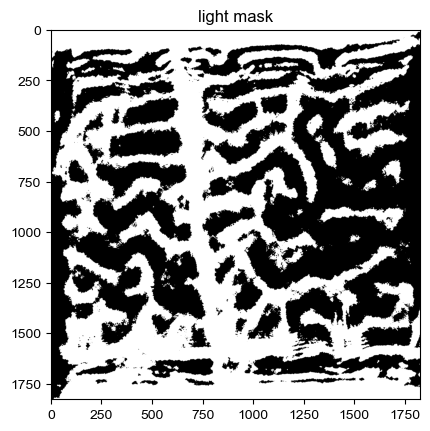

(1827, 1827)
light_pixels 1689554
total_pixels 3337929
dark_pixels 1648375
ratio 0.5061683457017809
OneView_200kV_10kX_FGT_A1_0019_037K_2.25um.png ratio of light pixels to total pixels:  0.5061683457017809


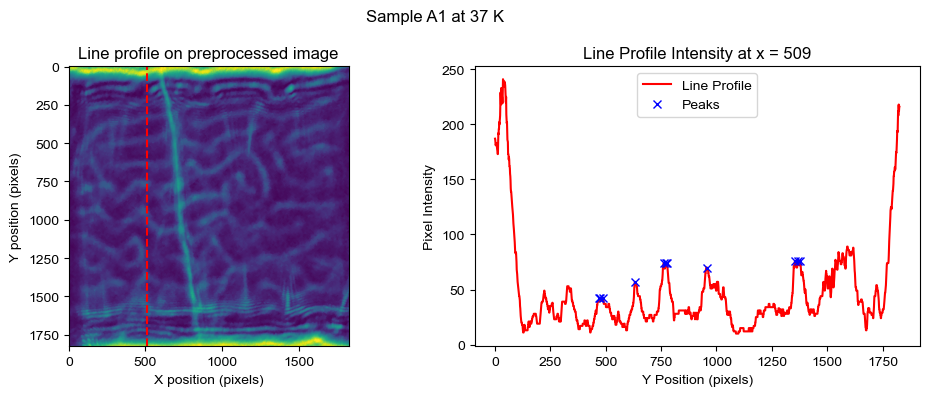

Number of peaks: 11
Average peak-to-peak spacing: 90.70 pixels
peak- to-peak spacing Stdev: 121.79 pixels


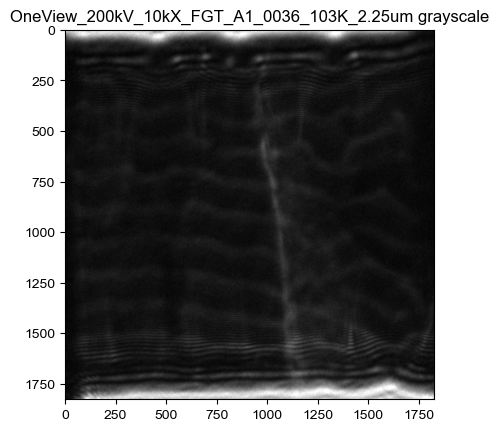

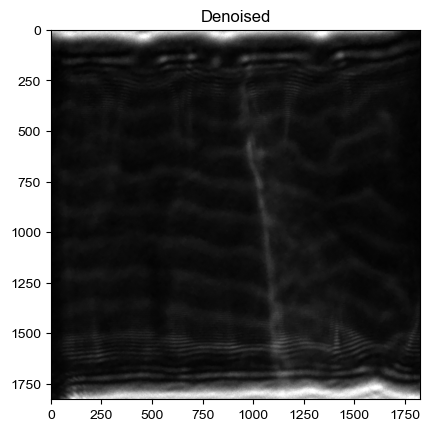

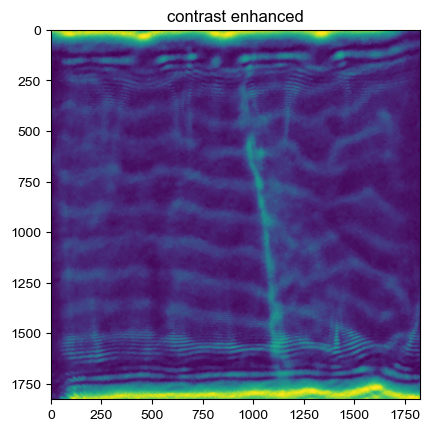

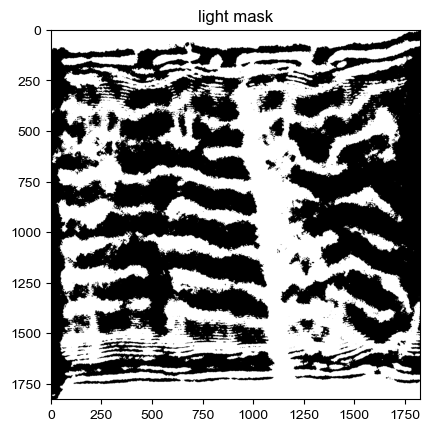

(1827, 1827)
light_pixels 1654918
total_pixels 3337929
dark_pixels 1683011
ratio 0.49579185177395924
OneView_200kV_10kX_FGT_A1_0036_103K_2.25um.png ratio of light pixels to total pixels:  0.49579185177395924


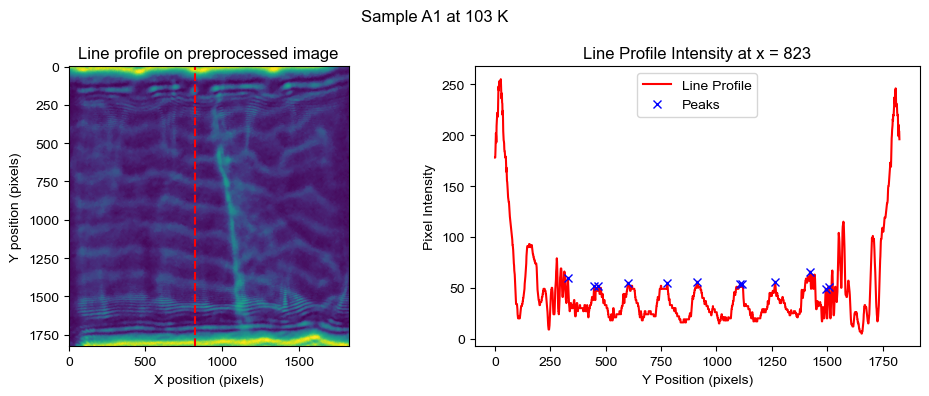

Number of peaks: 12
Average peak-to-peak spacing: 107.00 pixels
peak- to-peak spacing Stdev: 64.62 pixels


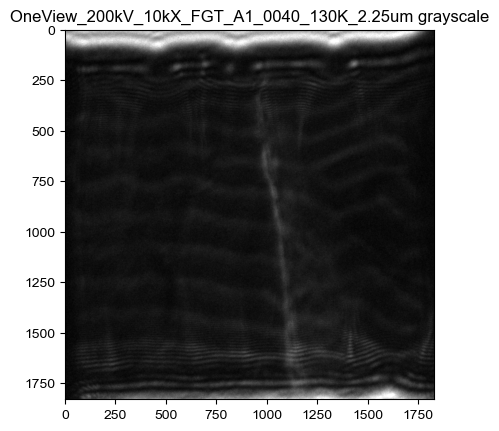

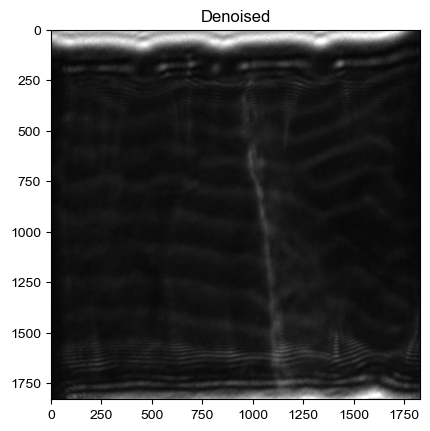

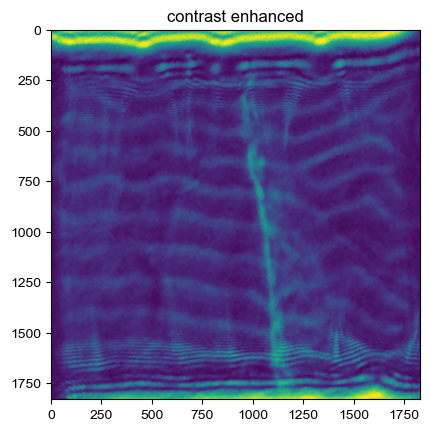

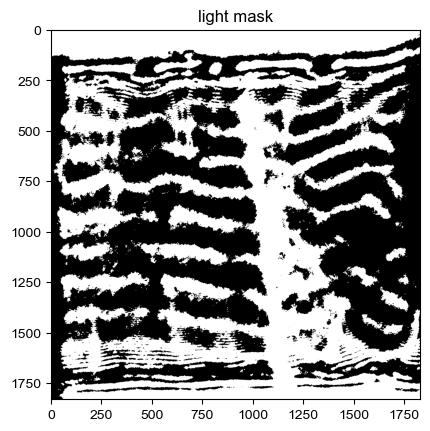

(1830, 1830)
light_pixels 1618703
total_pixels 3348900
dark_pixels 1730197
ratio 0.48335363850816687
OneView_200kV_10kX_FGT_A1_0040_130K_2.25um.png ratio of light pixels to total pixels:  0.48335363850816687


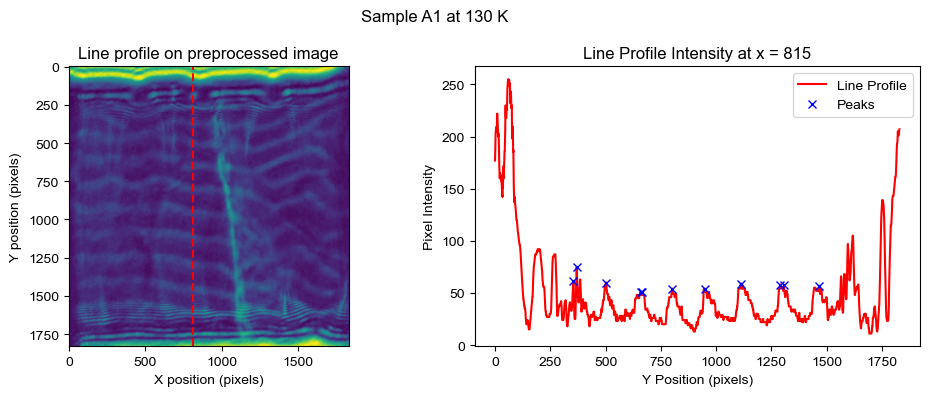

Number of peaks: 11
Average peak-to-peak spacing: 111.10 pixels
peak- to-peak spacing Stdev: 65.61 pixels


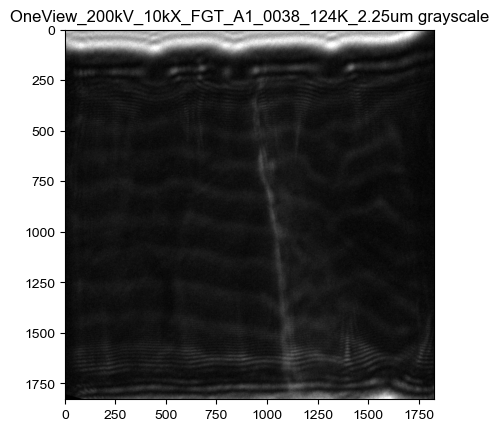

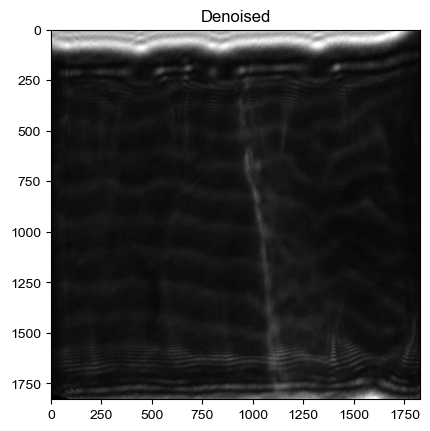

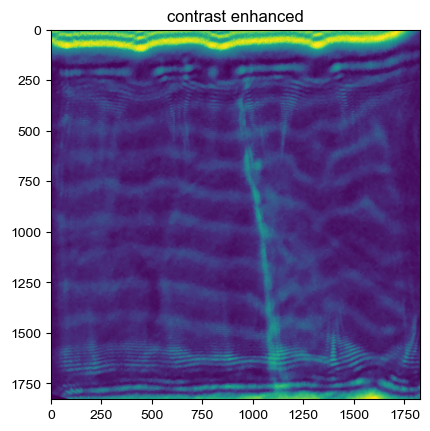

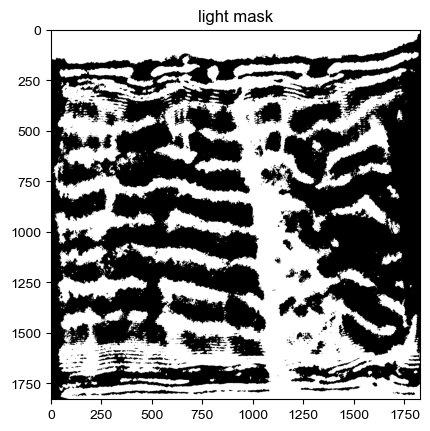

(1829, 1829)
light_pixels 1618418
total_pixels 3345241
dark_pixels 1726823
ratio 0.4837971315071171
OneView_200kV_10kX_FGT_A1_0038_124K_2.25um.png ratio of light pixels to total pixels:  0.4837971315071171


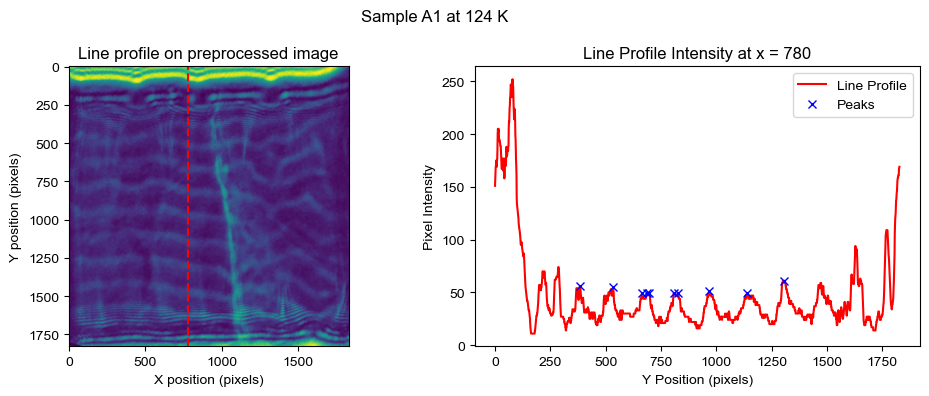

Number of peaks: 10
Average peak-to-peak spacing: 102.44 pixels
peak- to-peak spacing Stdev: 63.05 pixels


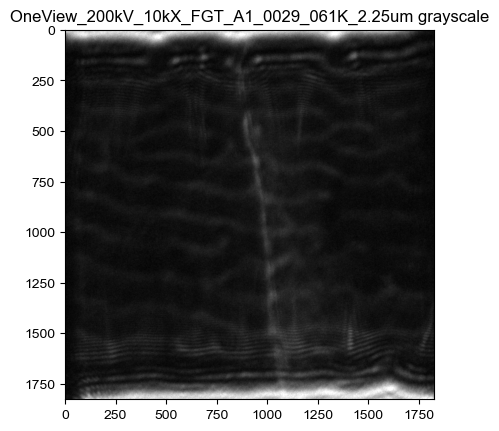

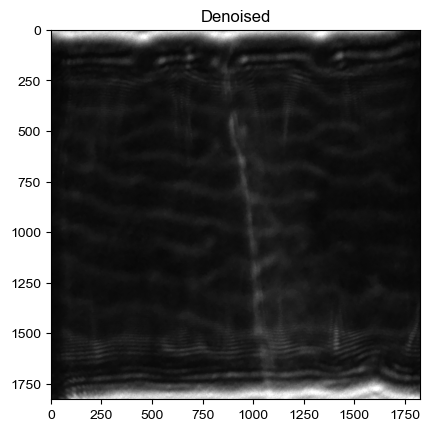

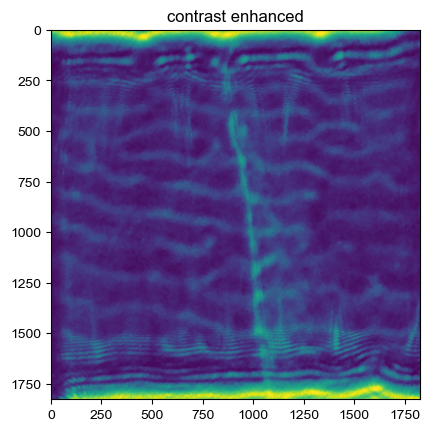

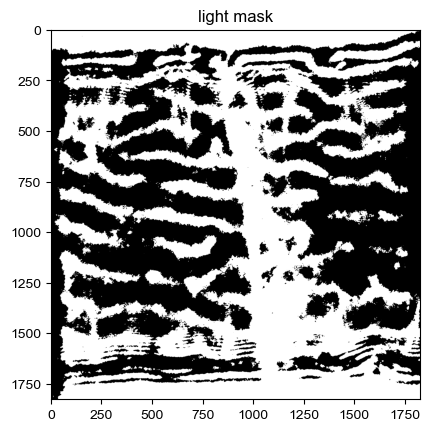

(1827, 1827)
light_pixels 1677518
total_pixels 3337929
dark_pixels 1660411
ratio 0.5025625170577325
OneView_200kV_10kX_FGT_A1_0029_061K_2.25um.png ratio of light pixels to total pixels:  0.5025625170577325


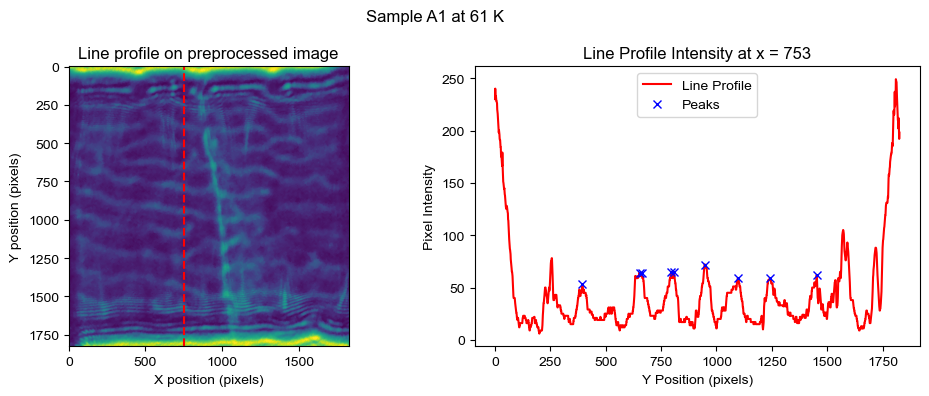

Number of peaks: 9
Average peak-to-peak spacing: 132.25 pixels
peak- to-peak spacing Stdev: 81.93 pixels


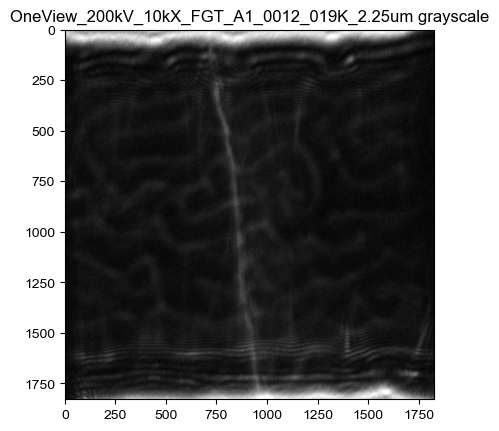

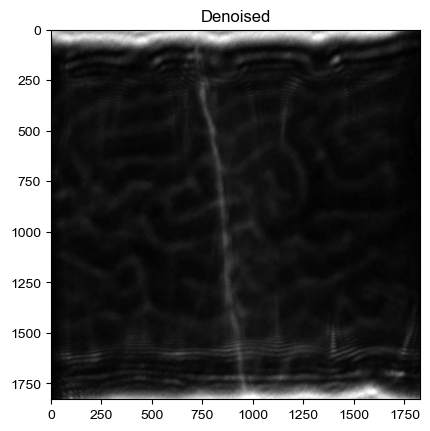

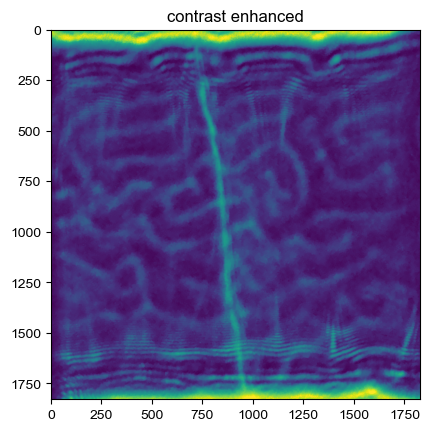

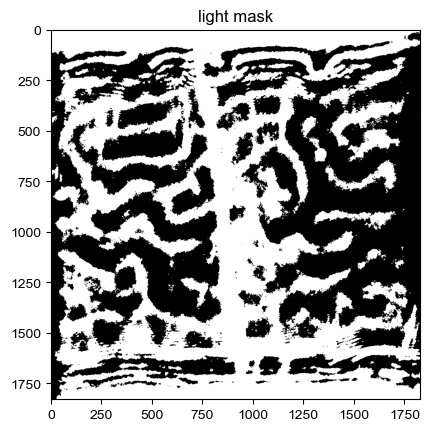

(1829, 1829)
light_pixels 1716111
total_pixels 3345241
dark_pixels 1629130
ratio 0.5130007075723393
OneView_200kV_10kX_FGT_A1_0012_019K_2.25um.png ratio of light pixels to total pixels:  0.5130007075723393


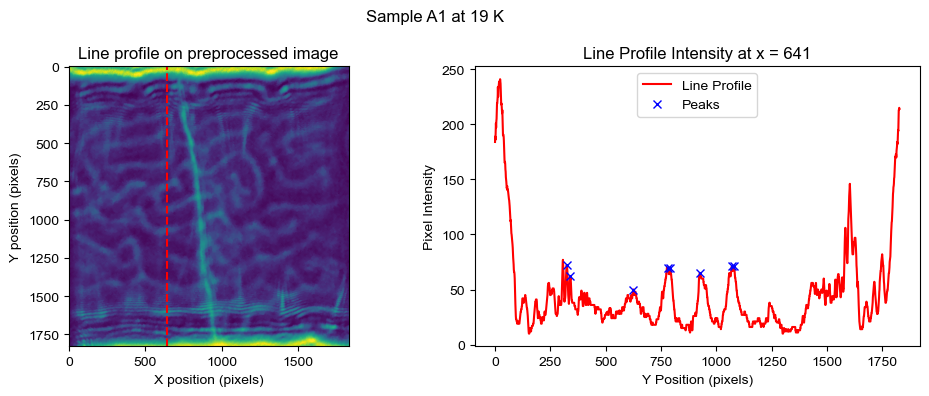

Number of peaks: 8
Average peak-to-peak spacing: 108.00 pixels
peak- to-peak spacing Stdev: 94.31 pixels


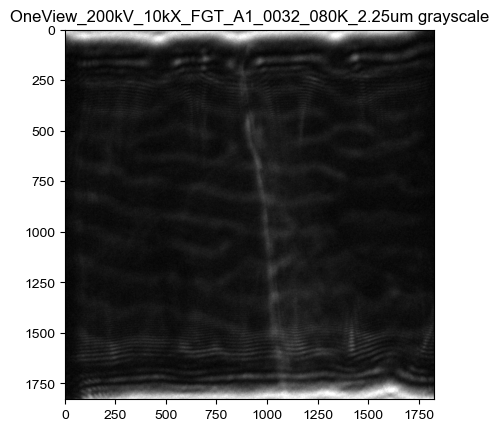

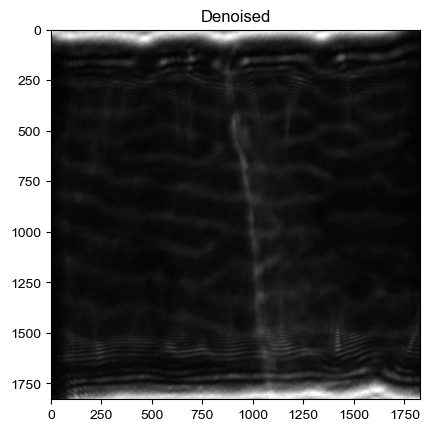

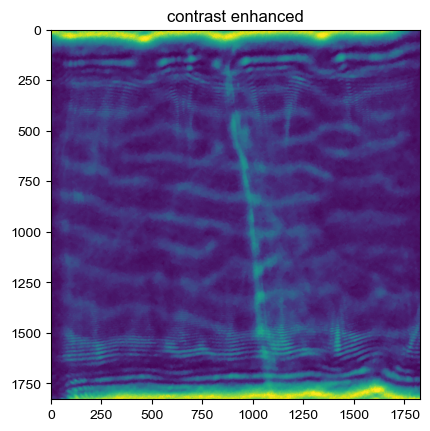

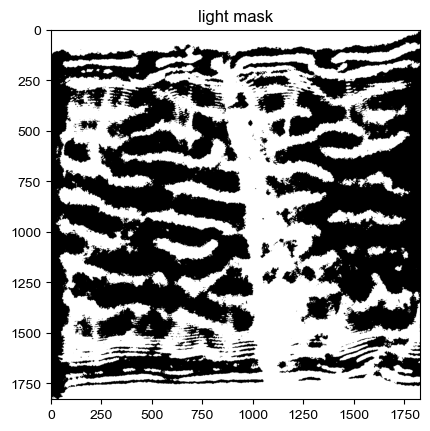

(1829, 1829)
light_pixels 1672497
total_pixels 3345241
dark_pixels 1672744
ratio 0.4999630818825908
OneView_200kV_10kX_FGT_A1_0032_080K_2.25um.png ratio of light pixels to total pixels:  0.4999630818825908


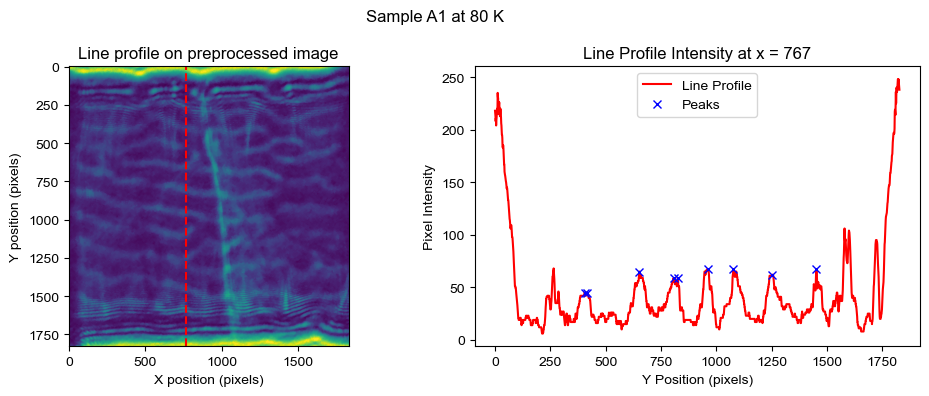

Number of peaks: 9
Average peak-to-peak spacing: 130.75 pixels
peak- to-peak spacing Stdev: 75.75 pixels


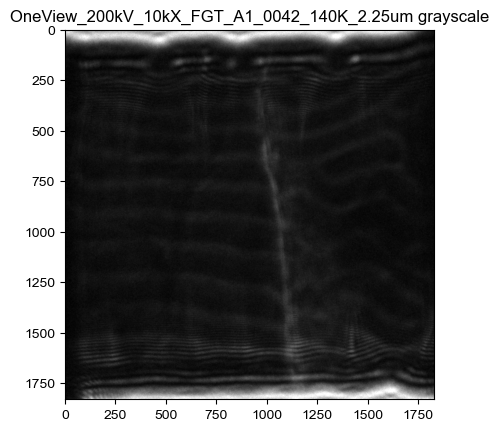

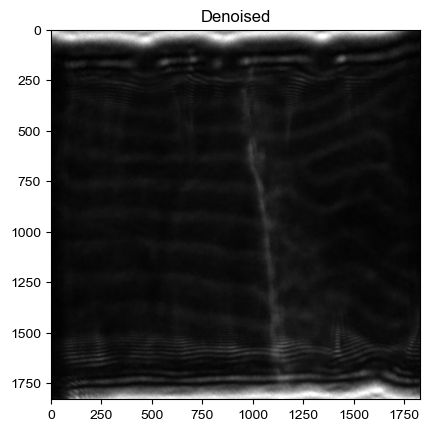

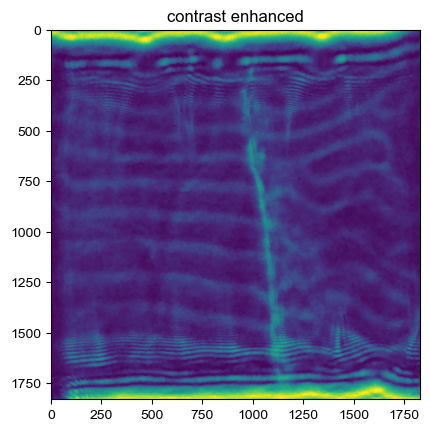

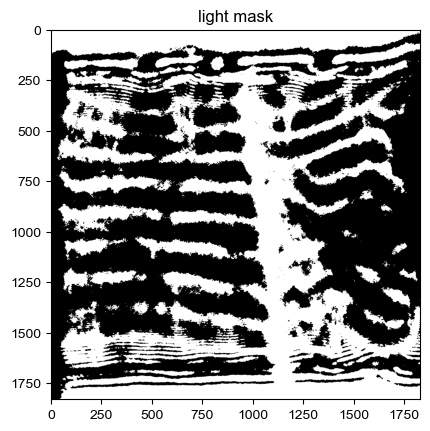

(1831, 1831)
light_pixels 1532276
total_pixels 3352561
dark_pixels 1820285
ratio 0.457046419140472
OneView_200kV_10kX_FGT_A1_0042_140K_2.25um.png ratio of light pixels to total pixels:  0.457046419140472


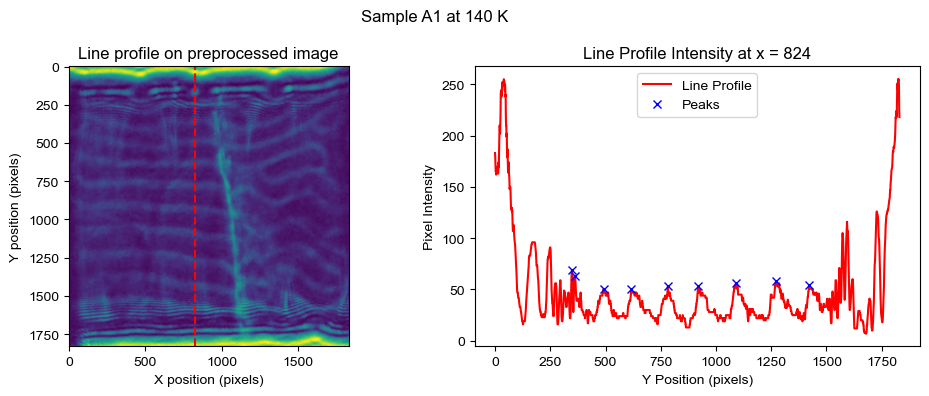

Number of peaks: 9
Average peak-to-peak spacing: 134.12 pixels
peak- to-peak spacing Stdev: 49.48 pixels


In [37]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import re
from scipy.signal import find_peaks

# Load the image
current_path = os.getcwd()
folder_name= '6000OLF_MedRibbon_2mmDefocus_20DegTilt_Rotated15Deg'
DATA_PATH = os.path.join(current_path, 'images', folder_name) #path to where the data is saved
plt.rcParams['font.family'] = 'Arial'



#image preprocessing: denoise and contrast enhance
def preprocess_images(image, image_filename): 
    #denoise image to speed up processing time: #seems to make image quality worse! 
    image_denoised = cv2.fastNlMeansDenoising(image, None, 4, 7, 21)
    # image_denoised = image

    
    #plot: 
    plt.imshow(image_denoised, cmap='gray')
    plt.title('Denoised')
    plt.show()

    #enhance the contrast: 
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(image_denoised)
    plt.imshow(contrast_enhanced)
    plt.title('contrast enhanced')
    plt.show()
    
    return contrast_enhanced

#do the binary thresholding for processing:
def thresholding(image,image_filename):
     # Threshold to detect light lines: higher threshold for bright features
    _, light_mask = cv2.threshold(image, 35, 255, cv2.THRESH_BINARY) #first number is threshold, second number is what it converts pixels to 
    #plot: 
    plt.imshow(light_mask, cmap='gray')
    plt.title('light mask')
    plt.show()
    
    
    #result is either light_mask or light_edges, depending on what you want to do: 
    result= light_mask
    
    # Save the result
    output_path = os.path.join(DATA_PATH, 'processed')
    output_filename = os.path.join(output_path, image_filename.replace('.png','_thresholded.png'))
    cv2.imwrite(output_filename, result)
    return result

#light pixel ratio of each file (light pixels/ total pixels)
def image_lightdark_ratio(image, image_filename):
    light_pixels = cv2.countNonZero(image)
    print(image.shape)
    print('light_pixels', light_pixels)
    height, width = image.shape
    total_pixels = height*width
    print('total_pixels', total_pixels)
    dark_pixels = total_pixels-light_pixels
    print('dark_pixels', dark_pixels)
    ratio_light_to_total= light_pixels/total_pixels
    print('ratio', ratio_light_to_total)
    
    return ratio_light_to_total

#extract line profile, plot, and find peaks
def line_profile_func(filename, image, x_value):
    
   #find the bright vertical line in the center of the image so that all line profiles can be relative to that
    #take a line profile across the y axis and find maximum
    
    line_profile_y= image[750, :]
    #find max of this, then find index of that, then that = the correct x_value because we are indexing from 0 
    bright_center_x= np.argmax(line_profile_y)
    #we can comment this out if an image doesn't have a feature like this to align to, function still can take manual input
    
    x_value=bright_center_x-200 #offset by 200 pixels left

    #below (mostly) from chat GPT

    # --- Extract the vertical line profile ---
    line_profile = image[:, x_value]

    # --- Plot the image and overlay the vertical line ---
    plt.figure(figsize=(10, 4))
    
    # --- Detect peaks ---
    # You can adjust `distance` or `prominence` as needed
    #sliced data from some x value to another x value to search for peaks. Peaks returns the number of pixels into the slice the 
    #peaks are found at. Need to shift them back. 
    
    SEARCH_MIN= 315
    SEARCH_MAX= 1515
    peaks, _ = find_peaks(line_profile[SEARCH_MIN:SEARCH_MAX], prominence=25, distance=5)
    peaks= peaks+ SEARCH_MIN
    
    # Image with vertical line: place line where the line profile will be extracted from
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axvline(x=x_value, color='red', linestyle='--')
    plt.title('Line profile on preprocessed image')
    plt.xlabel('X position (pixels)')
    plt.ylabel('Y position (pixels)')
    
    #make title for figure: 
    temp= extract_temperature(filename)
    plt.suptitle('Sample A1 at '+temp+ ' K')

    # plot line profile
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(line_profile)), line_profile, label='Line Profile', color='red')
    plt.plot(peaks, line_profile[peaks], "bx", label='Peaks')
    plt.title(f'Line Profile Intensity at x = {x_value}')
    plt.xlabel('Y Position (pixels)')
    plt.ylabel('Pixel Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Calculate peak-to-peak spacing ---
    if len(peaks) > 1:
        spacings = np.diff(peaks)  # difference between consecutive peaks (in pixels)
        avg_spacing = np.mean(spacings)
        std_spacing = np.std(spacings)
    else:
        spacings = []
        avg_spacing = None

    # --- Print results ---
    print(f"Number of peaks: {len(peaks)}")
    if avg_spacing is not None:
        print(f"Average peak-to-peak spacing: {avg_spacing:.2f} pixels")
        print(f"peak- to-peak spacing Stdev: {std_spacing:.2f} pixels")
    else:
        print("Not enough peaks to calculate spacing.")
    num_peaks= len(peaks)
    return num_peaks, avg_spacing, std_spacing
    
#get temperature from filename (from ChatGPT): 
def extract_temperature(filename):
    # Use a regular expression to match the pattern 'xxxK' preceded by an underscore
    match = re.search(r'_(\d{3,})K', filename)
    
    # If a match is found, return the matched temperature
    if match:
        temp_str = match.group(1)  # Get the temperature as string (e.g., '017')
        return str(int(temp_str))  # Convert to int and back to string to remove leading zeroes
    else:
        raise ValueError("Temperature not found in filename")

#loop through everything in folder and do all images at once
file_stats=[] #to be written to the csv file
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".png"): #don't include txt files or folders
        #load the image:
        image_path = os.path.join(DATA_PATH, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # load image, convert to grayscale when loading
        #Display grayscale (unprocessed) image
        plt.imshow(image, cmap='gray')
        plt.title(filename.replace('.png', ' ')+'grayscale')
        plt.show() 
        #preprocess image:
        temperature= extract_temperature(filename)
        preprocessed_image = preprocess_images(image, filename)
        thresholded_image= thresholding(preprocessed_image, filename)
        #get light to dark ratio: 
        image_ratio=image_lightdark_ratio(thresholded_image, filename)
        print(filename, 'ratio of light pixels to total pixels: ', image_ratio)
        #line profile
        num_peaks, avg_spacing, std_spacing = line_profile_func(filename, preprocessed_image, 500)
        file_stats.append([filename, round(image_ratio,3), temperature, num_peaks, round(avg_spacing, 3), round(std_spacing, 3)])

        


#export as csv file with the light dark ratios: 
csv_filename= 'data_summary.csv'
csv_path=  output_path = os.path.join(DATA_PATH, 'processed',csv_filename)#csv filepath


with open(csv_path, 'w', newline='') as csvfile: 
    #write header
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['File name', 'Temperature (K)','Light pixel to total pixel ratio', 'Number of peaks across vertical line profile', 
                        'Avg peak spacing', 'Standard Deviation of Peak Spacing'])
    for name, ratio, temperature, num_peaks, peak_spacing, std_peak in file_stats: 
        csvwriter.writerow([name, temperature, ratio, num_peaks, peak_spacing, std_peak])
        
